# Multi-asset option pricing - Monte Carlo - exchange option

In [1]:
import sys
sys.path.append('..')


from optionpricer import payoff
from optionpricer import option
from optionpricer import bspde
from optionpricer import analytics
from optionpricer import parameter as prmtr
from optionpricer import path
from optionpricer import generator
from optionpricer import montecarlo

import numpy as np
from scipy import linalg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# option and market properties 
expiry    = 1.0/12.0 # time until expiry (annualized)
r0        = 0.094    # interest rate (as decimal, not percentage) 

# properties of the underlyings
sig=np.array([0.05,0.09]) # volatility (annualized) for underlyings [vol stock 1, vol stock 2]
rho = 0.8                 # correlation between the two underlyings
correlation_matrix = np.array([[1.0,rho],[rho,1.0]])

# the spot values we will want to price the option at for the two underlyings
spot0 = np.linspace(30.0,70.0,30)
spot1 = np.linspace(40.0,60.0,20)
# create a meshgrid to easily run over all combinations of spots, and for ease of plotting later 
SPOT0,SPOT1 = np.meshgrid(spot0,spot1)

# # use r0, and the volatilities (elements of sig) to make a SimpleParam objects containing these values
r_param   = prmtr.SimpleParam(r0)
sig0_p = prmtr.SimpleParam(sig[0])
sig1_p = prmtr.SimpleParam(sig[1])

In [9]:
# we can use the correlation matrix of the underlyings to construct the covariance matrix
covars = correlation_matrix*np.outer(sig,sig)
print(covars)

# We can then Cholesky decompose the covariance matrix
L = linalg.cholesky(covars,lower=True)
# we obtain a lower traingular matrix which can be used to generate movements of the underlying 
# which obey the covariance (/correlation) we defined above
print(L)
print(np.dot(L,L.T))

# create a simpleArrayParam (this object stores an array which is constant in time) usung L 
cholesky_param = prmtr.SimpleArrayParam(L)

[[0.0025 0.0036]
 [0.0036 0.0081]]
[[0.05  0.   ]
 [0.072 0.054]]
[[0.0025 0.0036]
 [0.0036 0.0081]]


In [10]:
# define the Spread option - with strike of 0 to make it an exchange option
exchange_po     = payoff.SpreadPayOff(0.0)
# also valid for payoff of exchnage option: exchange_po=payoff.ExchangePayOff()
exchange_option = option.VanillaOption(exchange_po,expiry)

In [11]:
# define the random generator for problem - here normally districuted log returns
gen_norm = generator.Normal()
# decorate the generator, making it an antithetic generator for variance reduction
gen_norm_antith = generator.Antithetic(gen_norm)

In [12]:
# Define a multiasset montecarlo pricer
mc_pricer = montecarlo.MAMonteCarlo(exchange_option,gen_norm_antith)

# initialize arrays for prices 
mc_prices = np.zeros_like(SPOT0)
# we also initialize an array of option prices using the analytic magrabe price of exchange option
magrabe_prices = np.zeros_like(SPOT0)

# loop over spots, and calculate the price of the option
for ind0 in range(SPOT0.shape[0]):
    for ind1 in range(SPOT0.shape[1]):
        s = np.array([SPOT0[ind0,ind1],SPOT1[ind0,ind1]])
        mc_prices[ind0,ind1] = mc_pricer.solve_price(s,r_param,cholesky_param,eps_tol=0.0001)
        magrabe_prices[ind0,ind1] =  analytics.margrabe_option_price(s,expiry,covars)


In [30]:
# set up plotting parameters for nice to view plots
sns.set()
mpl.rcParams['lines.linewidth']  = 2.0
mpl.rcParams['font.weight']      = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titlesize']   = 12
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['font.size']        = 12
mpl.rcParams['legend.frameon']   = False
mpl.rcParams['figure.figsize']   = [15,10]

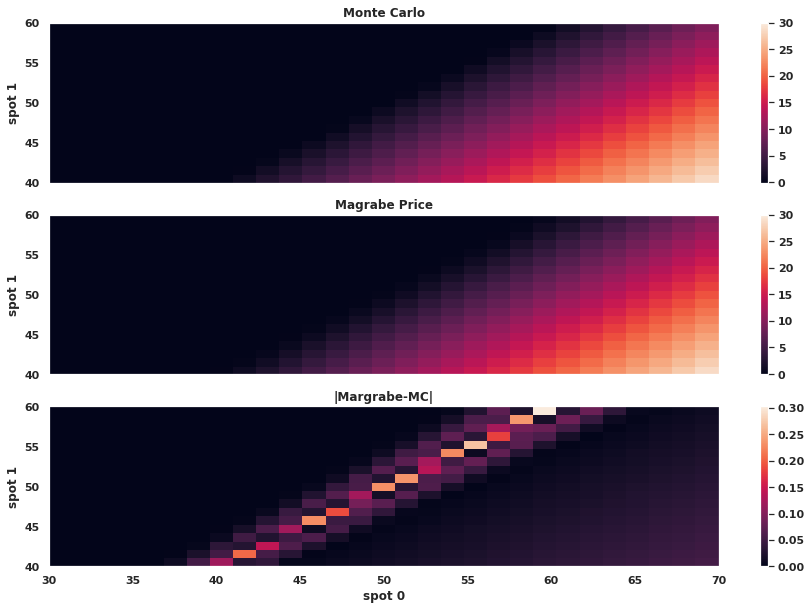

In [33]:
# we will plot the monte carlo, magrabe price, and the differen between the two (the error)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

# calculate values of min and max expected values 
# use to set colormap max/min values to ensure they're the same for both plots of price
vmin_=min(np.amin(mc_prices),np.amin(magrabe_prices))
vmax_=max(np.amax(mc_prices),np.amax(magrabe_prices))

# subplot of Monte Carlo
im1 = ax1.pcolormesh(spot0,spot1,mc_prices,vmin=vmin_,vmax=vmax_)
plt.colorbar(im1,ax=ax1)

# subplot of Magrabe price
im2 = ax2.pcolormesh(spot0,spot1,magrabe_prices,vmin=vmin_,vmax=vmax_)
plt.colorbar(im2,ax=ax2)

# subplot of error
im3 = ax3.pcolormesh(spot0,spot1,np.abs(magrabe_prices-mc_prices))
plt.colorbar(im3,ax=ax3)
ax3.set_xlabel('spot 0')

# set titles and y lables of subplots
titles = ['Monte Carlo','Magrabe Price','|Margrabe-MC|']
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.set_ylabel('spot 1')
    ax.set_title(titles[i])

plt.show()